<a href="https://colab.research.google.com/github/poojamahajan0712/COVID_tweet_analysis/blob/master/COVID_Tweet_Sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading required libraries
#!pip install contractions
#!pip install wordcloud==1.8.0

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
import contractions
#nltk.download('stopwords')


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score

pd.options.display.max_colwidth = 600

In [ ]:
# Reading COVID tweet data 
df = pd.read_csv('Corona_NLP_train.csv',encoding='latin1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative


In [ ]:
# shape of the data
print('Shape of the Data',df.shape)
print('*'*50)
# Missing values present 
print('Count of missing values')
df.isnull().sum()

Shape of the Data (41157, 6)
**************************************************
Count of missing values


UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
## Number of uniques for each column-- data for 30 days of tweet, unique locations 12220
df.nunique()

UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

Minimum date 2020-03-16
Maximum date 2020-04-14


Text(0.5, 1.0, 'Tweets distribution')

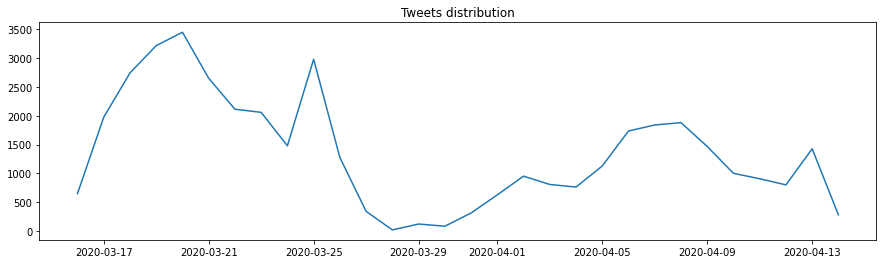

In [ ]:
# min and max dates 
df['TweetAt']=pd.to_datetime(df['TweetAt'],dayfirst=True)
print('Minimum date',df['TweetAt'].dt.date.min())
print('Maximum date',df['TweetAt'].dt.date.max())

## Tweets per day 
plt.figure(figsize=(15,4))
plt.plot(df['TweetAt'].value_counts().sort_index())  ## max number of tweets before 25th March
plt.title('Tweets distribution')

In [ ]:
# Understanding Location variable     # some noisy location names present
df['Location'].unique()[:60]

array(['London', 'UK', 'Vagabonds', nan, 'Ã\x9cT: 36.319708,-82.363649',
       '35.926541,-78.753267', 'Austria', 'Atlanta, GA USA',
       'BHAVNAGAR,GUJRAT', 'Makati, Manila', 'Pitt Meadows, BC, Canada ',
       'Horningsea', 'Chicago, IL', 'Houston, Texas', 'Saudi Arabia',
       'Ontario, Canada', 'North America', 'Denver, CO',
       'southampton soxx xxx', 'Global', 'Downstage centre',
       'Ketchum, Idaho', 'Everywhere You Are!', 'New York, NY',
       'Someplace, USA', 'Markham, Ontario', 'Virginia, USA',
       'London, England', 'Sverige', 'Where The Wild Things Are',
       'Canada', 'United States', 'Fort Worth, Texas', 'Houston',
       'Vancouver, British Columbia', 'Midrand', 'Drogheda',
       'Columbia, MO', 'Arkansas, USA', 'Washington, DC', 'Ohio, USA',
       'Ogden, UT', 'West Midlands, England', 'Reno, NV', 'San Clemente',
       'Spokane Valley, WA', 'Drifter ', 'Hamilton, Ontario',
       'Dallas, TX', 'Boston', 'The European Union',
       'Melissa Schuman i

Text(0.5, 1.0, 'Top 10 Locations with maximum Tweets')

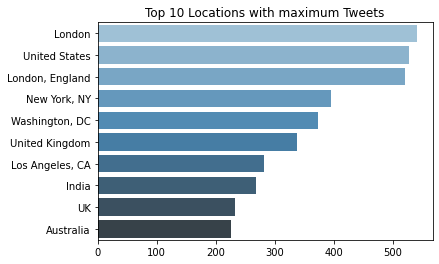

In [ ]:
## Top Locations with maximum number of tweets
a=df['Location'].value_counts().head(10)
sns.barplot(y=a.index,x=a.values,palette="Blues_d").set_title('Top 10 Locations with maximum Tweets')

Positive              27.75
Negative              24.10
Neutral               18.74
Extremely Positive    16.09
Extremely Negative    13.32
Name: Sentiment, dtype: float64


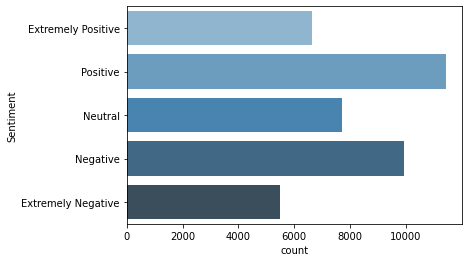

In [ ]:
## Understanding Sentiment column 

print(round((df['Sentiment'].value_counts(normalize=True))*100,2))
sns.countplot(y=df['Sentiment'],palette="Blues_d",
              order=["Extremely Positive", "Positive","Neutral","Negative","Extremely Negative"])

In [ ]:
## Text Cleaning  and steps -- some basic steps can be done 
df['OriginalTweet'].head()

# on checking tweets - we can see lot of special character tags , urls, contractions

0                                                                                                                                                                                                                       @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1                                                                                         advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
2                                                                                                                                                                                                   Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
3     My food st

count    41157.000000
mean         0.416916
std          1.116992
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         21.000000
Name: cnt_mentions, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of count of mentions')

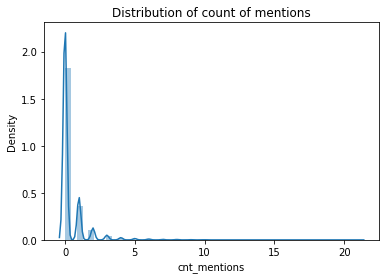

In [ ]:
# creating a column as number of mentions
df['cnt_mentions']=df['OriginalTweet'].apply(lambda x :len([t for t in x.split() if t.startswith('@') ]))
print(df['cnt_mentions'].describe())
sns.distplot(df['cnt_mentions']).set_title('Distribution of count of mentions') ## quite skewed , mostly 0-3 mentions in each tweet

In [ ]:
## so we saw max value for mentions is 21 , let's check how these tweets look like -- seems like all are just tags and thus can be removed.
df[df['cnt_mentions']==21]



,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cnt_mentions
22994,26793,71745,NaN,2020-03-25,@twigliot @DreaVilleneuve @tedbauer2003 @TheComicHunter @biggreenpen @MrLexJay @JimCanto @ideabloke @JoelRRenner @GabrielSurfCat @BrendaMKramer @YEPBusiness @katyb_spencer @joshmccormack @Renoe @bikespoke @nplusg @MattJ_O @plainwildcatfan @johndburger @ho,Neutral,21
31440,35239,80191,NaN,2020-04-06,@Jaisans @JamesRider3 @AanthanurDC @doom37455413 @ILuvCO2 @Andrewemcameron @geoffmprice @ElectroPig @glinch72 @IngersolRobert @AgtRigor @Bitakarma @AtomsksSanakan @DevinNunesGoat1 @Article3S @Jamz129 @rm_simmons @RustyAway @JosephsEddy @MikeH_MapleGrov @i,Neutral,21
31657,35456,80408,"North Carolina, USA.",2020-04-07,@ThomONeil1 @bobbiejaneV @media_auntie @BonJS0370 @ldog562 @zazzybritches @pecriel @kristyshl @HurricaneEve81 @MaryHow16 @SafiMaasai @alice4u2010 @ReneTremblay13 @stweetleigh @poppij @Dianne2429 @paulinef136 @mccunecicki @TilghmanChris @StaryStaryNlght @b,Neutral,21


In [ ]:
df.drop(df[df['cnt_mentions'] >20].index , inplace=True)

In [ ]:
df.shape

(41154, 7)

In [ ]:
# creating a column as number of hashtags
df['cnt_hashtags']=df['OriginalTweet'].apply(lambda x :len([t for t in x.split() if t.startswith('#') ]))
df['cnt_hashtags'].describe()

count    41154.000000
mean         1.965398
std          2.844109
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         30.000000
Name: cnt_hashtags, dtype: float64

In [ ]:
# Data Cleaning 

# remove urls 
df['processed'] = df['OriginalTweet'].replace(r'http\S+', ' ', regex=True)

# convert to lowercase
df['processed']=df['processed'].str.lower()

# contractions
df['processed']=df['processed'].apply(contractions.fix)

## removing account names -- basically after @ words -- those are usernames
df['processed']=df['processed'].apply(lambda x :[t for t in x.split() if not t.startswith('@')] ).apply(lambda x: ' '.join(x))

## removing special characters and number
df['processed'] = df['processed'].replace(r'[^A-Za-z]+', ' ', regex=True)

## Stripping white space
df['processed']=df['processed'].apply(lambda x : x.strip())

## removing stopwords
stop = stopwords.words('english')
stop.extend(['amp','aaa'])

df['processed'] = df['processed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

print('Shape of dataset',df.shape)

## removing completely blank records 
df=df[df['processed']!='']

print('After removing empty records, shape of the dataset',df.shape)

Shape of dataset (41154, 9)
After removing empty records, shape of the dataset (41122, 9)


In [ ]:
## Number of words in tweet-  calculating length 
df['len']=df['processed'].apply(lambda x : len([ t for t in x.split()]))
df['len'].describe()

count    41122.000000
mean        17.456884
std          6.432103
min          1.000000
25%         12.000000
50%         18.000000
75%         22.000000
max         46.000000
Name: len, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of length')

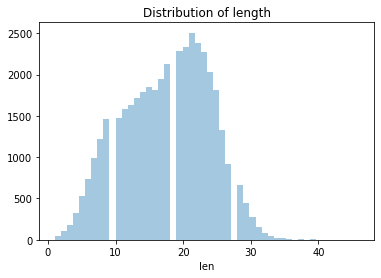

In [ ]:
sns.distplot(df['len'],kde=False).set_title('Distribution of length') ## max tweets are about 20 words long

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


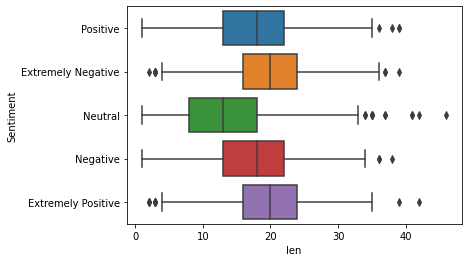

In [ ]:
## Relation between sentiment and Tweet length
sns.boxplot(df['len'],y=df['Sentiment'])

In [ ]:
## Separating independent and dependent variables
X=df['processed']

df['target']=df['Sentiment'].apply(lambda x : 1 if ((x=='Positive') | (x=='Extremely Positive'))
                                         else 2 if ((x=='Negative') | (x=='Extremely Negative'))
                                         else 0) 
y=df['target']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)

In [ ]:
df['target'].value_counts(normalize=True)

1    0.438792
2    0.374422
0    0.186786
Name: target, dtype: float64

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)

In [ ]:
def output(modelname):
    clf_pipeline= Pipeline([('tfidf',TfidfVectorizer(stop_words='english')),
                       ('clf',modelname)])
    clf_pipeline.fit(X_train,y_train)
    pred=clf_pipeline.predict(X_test)
    return(pred)

def results(modelname):
    pred=output(modelname)
    print('*'*50)
    print('Classification Report')
    print('*'*50)
    print(classification_report(y_test,pred))
    print('*'*50)
    print('Accuracy Score',round(accuracy_score(y_test,pred),3)*100)
    

In [ ]:
print('Using Naive Bayes')
results(MultinomialNB())

Using Naive Bayes
**************************************************
Classification Report
**************************************************
              precision    recall  f1-score   support

           0       0.92      0.02      0.05      2269
           1       0.60      0.89      0.72      5427
           2       0.72      0.65      0.68      4641

    accuracy                           0.64     12337
   macro avg       0.74      0.52      0.48     12337
weighted avg       0.70      0.64      0.58     12337

**************************************************
Accuracy Score 64.2


In [ ]:
print('Using Random Forest')
results(RandomForestClassifier())

Using Random Forest
**************************************************
Classification Report
**************************************************
              precision    recall  f1-score   support

           0       0.61      0.64      0.62      2269
           1       0.76      0.79      0.77      5427
           2       0.75      0.70      0.73      4641

    accuracy                           0.73     12337
   macro avg       0.71      0.71      0.71     12337
weighted avg       0.73      0.73      0.73     12337

**************************************************
Accuracy Score 72.89999999999999


In [ ]:
print('Using Xgboost')
results(XGBClassifier())



Using Xgboost
**************************************************
Classification Report
**************************************************
              precision    recall  f1-score   support

           0       0.55      0.37      0.44      2269
           1       0.62      0.79      0.69      5427
           2       0.71      0.60      0.65      4641

    accuracy                           0.64     12337
   macro avg       0.63      0.58      0.59     12337
weighted avg       0.64      0.64      0.63     12337

**************************************************
Accuracy Score 64.0


In [ ]:
print('Using SVM')
results(LinearSVC())

Using SVM
**************************************************
Classification Report
**************************************************
              precision    recall  f1-score   support

           0       0.70      0.64      0.67      2269
           1       0.82      0.84      0.83      5427
           2       0.81      0.81      0.81      4641

    accuracy                           0.79     12337
   macro avg       0.77      0.76      0.77     12337
weighted avg       0.79      0.79      0.79     12337

**************************************************
Accuracy Score 79.2


In [ ]:
pred=output(LinearSVC())

pd.Series(X_test).reset_index(drop=True, inplace=True)
pd.Series(y_test).reset_index(drop=True, inplace=True)
pred_df=pd.concat([pd.Series(X_test),pd.Series(y_test),pd.Series(pred)],axis=1)
pred_df.rename(columns={0:'Pred'},inplace=True)
print(pred_df.shape)
pred_df.head()

(12337, 3)


,processed,target,Pred
0,things grateful coming home months travel always lots tp sanitizer lysol house bought corox wipes flight home need hoarding watch coronavirus symptoms keep beer stocked,1,1
1,coronavirus family fined selling medical masks port coquitlam steep prices,0,0
2,life streatham aldi around ps local bossman man mini supermarket essentials need,0,0
3,oil prices falling amid covid recession beginning end fracking,2,2
4,must run two operations tomorrow get food funding since vancouver corona virus panic combined record homelessness rv army fentanyl crisis broke system coronavirusoutbreak covid wuhanvirus wuhancoronavirus wuhancoronavirusoutbreak coronavirus,2,2


Text(0.5, 1.0, 'Positive Sentiment')

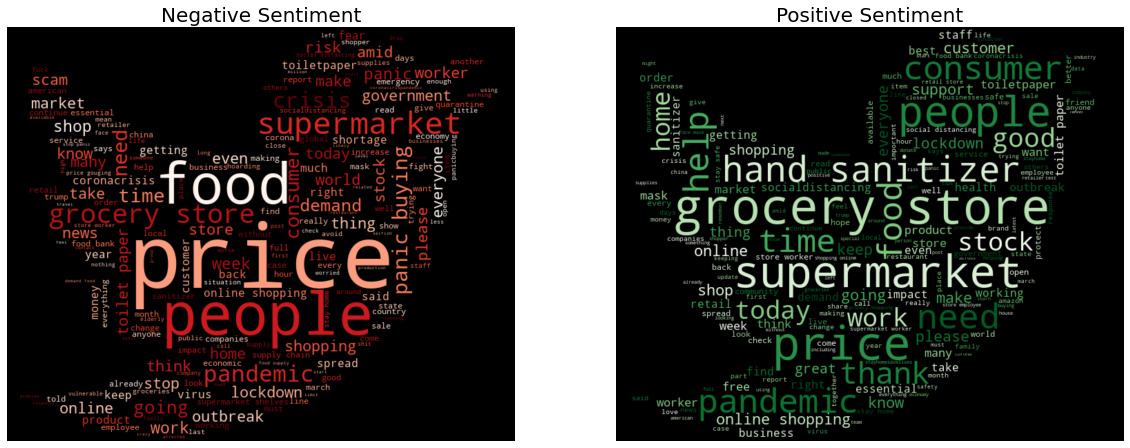

In [ ]:
## Final chosen model predictions cloud 
bird1=np.array(Image.open('Twitter-Logo.jpg'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])
stopwords = set(STOPWORDS)
stopwords.update(['covid','coronavirus','coronaviru','will','say','still','amp'])


wordcloud1 = WordCloud(mask=bird1,colormap="Reds",min_word_length=4,stopwords=stopwords,
                       collocation_threshold=20).generate(" ".join(pred_df[pred_df['Pred']==2]['processed']))
ax1.imshow(wordcloud1,interpolation="bilinear")
ax1.axis('off')
ax1.set_title('Negative Sentiment',fontsize=20)


wordcloud2 = WordCloud(mask=bird1,colormap="Greens",min_word_length=4,stopwords=stopwords,
                       collocation_threshold=20).generate(" ".join(pred_df[pred_df['Pred']==1]['processed']))
ax2.imshow(wordcloud2,interpolation="bilinear")
ax2.axis('off')
ax2.set_title('Positive Sentiment',fontsize=20)

Text(0.5, 1.0, 'Negative Sentiment')

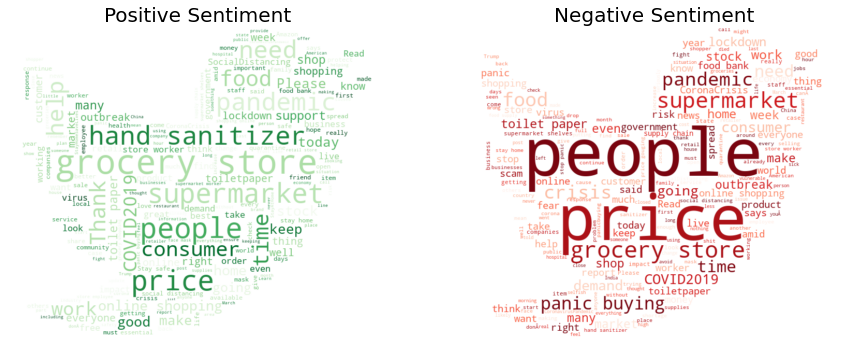

In [ ]:
## Wordcloud on original tweets
bird1=np.array(Image.open('Twitter-Logo.jpg'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 20])
stopwords = set(STOPWORDS)
stopwords.update(['covid','coronavirus','coronaviru','will','say','still','amp','https','COVID19','Covid_19'])

wordcloud4 = WordCloud(mask=bird1,colormap="Greens",min_word_length=4,stopwords=stopwords,background_color='white',
                       collocation_threshold=20).generate(" ".join(df[df['target']==1]['OriginalTweet']))
ax1.imshow(wordcloud4,interpolation="bilinear")
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=20)

wordcloud3 = WordCloud(mask=bird1,colormap="Reds",min_word_length=4,stopwords=stopwords,background_color='white',
                       collocation_threshold=20).generate(" ".join(df[df['target']==2]['OriginalTweet']))
ax2.imshow(wordcloud3,interpolation="bilinear")
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=20)



